In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
import tqdm
from ast import literal_eval
import json
from time import time

In [3]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

# Perfect Information, Perfect Output?

Removing uncertainty of the boostrap confidence intervals and instead using exact values of probabilities / moments to optimize we can test if the constraints used are sufficient to produce exact parameter values under optimization.

This has been done in "Marginal-Experiments/perfect_information_optimization" for "hyp" and "min" optimizations using probability bounds with single capture efficiencies, but now investigate for per cell capture efficiencies and moment constraints.

# Code

## Exact values

In [182]:
def exact_probabilities(params, beta, truncation_OB, truncationM_OB, delta=0.01):
    '''Compute exact values of marginal and joint stationary distributions'''

    # store
    bounds = {}

    # joint
    x1_values = scipy.stats.poisson.pmf(np.array([x1 for x1 in range(truncation_OB['min_x1_OB'], truncation_OB['max_x1_OB'] + 1)])[:, None], beta * params['k_tx_1'] / params['k_deg_1']).mean(axis=1)
    x2_values = scipy.stats.poisson.pmf(np.array([x2 for x2 in range(truncation_OB['min_x2_OB'], truncation_OB['max_x2_OB'] + 1)])[:, None], beta * params['k_tx_2'] / params['k_deg_2']).mean(axis=1)
    joint_values = x1_values.reshape(-1, 1) @ x2_values.reshape(1, -1)

    # marginals
    x1_Mvalues = scipy.stats.poisson.pmf(np.array([x1 for x1 in range(truncationM_OB['minM_x1_OB'], truncationM_OB['maxM_x1_OB'] + 1)])[:, None], beta * params['k_tx_1'] / params['k_deg_1']).mean(axis=1)
    x2_Mvalues = scipy.stats.poisson.pmf(np.array([x2 for x2 in range(truncationM_OB['minM_x2_OB'], truncationM_OB['maxM_x2_OB'] + 1)])[:, None], beta * params['k_tx_2'] / params['k_deg_2']).mean(axis=1)

    # delta widths for numerics
    bounds['x1'] = np.stack([x1_Mvalues - delta, x1_Mvalues + delta], axis=0)
    bounds['x2'] = np.stack([x2_Mvalues - delta, x2_Mvalues + delta], axis=0)
    bounds['joint'] = np.stack([joint_values - delta, joint_values + delta], axis=0)

    return bounds

In [183]:
def exact_moments(params, beta, delta=0.01):
    '''
    Compute exact moments for a reaction network with given parameters, applying
    given capture efficiency to product observed moments
    '''

    # only valid when no interaction
    if params['k_reg'] > 0:
        print("ERROR: Invalid for k_reg > 0")
        return None

    # capture efficiency moments
    E_beta = np.mean(beta)
    E_beta_sq = np.mean(beta**2)

    # OG moments
    E_x1_OG = params['k_tx_1'] / params['k_deg_1']
    E_x2_OG = params['k_tx_2'] / params['k_deg_2']
    E_x1_x2_OG = E_x1_OG * E_x2_OG

    # OB moments
    E_x1_OB = E_x1_OG * E_beta
    E_x2_OB = E_x2_OG * E_beta
    E_x1_x2_OB = E_x1_x2_OG * E_beta_sq

    # width for numerics
    eps = np.array([-delta, delta])

    # collect moments
    result_dict = {
        'E_x1': E_x1_OB + eps,
        'E_x2': E_x2_OB + eps,
        'E_x1_x2': E_x1_x2_OB + eps
    }

    return result_dict

## Pre processing

In [184]:
def summarise_truncation(truncation_OB, truncationM_OB):
    '''
    Summarise states included in collection of observed truncations
    '''

    # state set
    state_pairs = set()
    states = set()

    # add each state pair in truncation
    for x1_OB in range(truncation_OB['min_x1_OB'], truncation_OB['max_x1_OB'] + 1):
        for x2_OB in range(truncation_OB['min_x2_OB'], truncation_OB['max_x2_OB'] + 1):

            # add to set
            state_pairs.add((x1_OB, x2_OB))
            states.add(x1_OB)
            states.add(x2_OB)

    # also add any single states (not pairs) in marginal truncation that were missed
    for x1_OB in range(truncationM_OB['minM_x1_OB'], truncationM_OB['maxM_x1_OB'] + 1):
        states.add(x1_OB)
    for x2_OB in range(truncationM_OB['minM_x2_OB'], truncationM_OB['maxM_x2_OB'] + 1):
        states.add(x2_OB)

    # collect info
    info_dict = {
        'state_pairs': state_pairs,
        'states': states
    }

    return info_dict

In [6]:
def Bm_trunc(x_OB, x_OG, beta):
    return np.mean(scipy.stats.binom.pmf(x_OB, x_OG, beta))

In [106]:
def marginal_truncation(x_OB, beta, thresh_OG=10**-6):

    # start at first non-zero coefficient
    x_OG = x_OB
    coeff = Bm_trunc(x_OB, x_OG, beta)

    # if not above threshold: increment until above
    while coeff < thresh_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store first state coeff >= thresh
    minM_OG = x_OG

    # increment until below threshold
    while coeff >= thresh_OG:

        # increment
        x_OG += 1

        # compute coeff
        coeff = Bm_trunc(x_OB, x_OG, beta)

    # store last state with coeff >= thresh (INCLUSIVE BOUND)
    maxM_OG = x_OG - 1

    return minM_OG, maxM_OG

In [209]:
def marginal_truncation_new(x_OB, beta):

    # min OG count 0
    minM_OG = 0

    # simply scale by mean capture
    maxM_OG = int(x_OB / np.mean(beta)) + 1

    return minM_OG, maxM_OG

In [186]:
def original_truncation(truncation_summary, beta, thresh_OG=10**-6, new_method=False):
    
    # collect OG truncations
    truncation_dict = {}

    # compute truncation for each observed count
    for x_OB in tqdm.tqdm(truncation_summary['states']):
        
        if new_method:
            minM_OG, maxM_OG = marginal_truncation_new(x_OB, beta)
        else:
            minM_OG, maxM_OG = marginal_truncation(x_OB, beta, thresh_OG)

        # store
        truncation_dict[x_OB] = (minM_OG, maxM_OG)

    return truncation_dict

In [187]:
def Bm_matrix(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta)

In [188]:
def compute_coefficients(truncation_summary, truncation_OG, beta, thresh_OG=10**-6):

    # store marginal grids
    marginal_grids = {}

    # loop over observed counts
    for x_OB in tqdm.tqdm(truncation_summary['states']):
        
        # get truncation
        minM_OG, maxM_OG = truncation_OG[x_OB]

        # construct arrays for broadcasting
        x_OB_arr = np.array([x_OB])[:, None]
        x_OG_arr = np.arange(minM_OG, maxM_OG + 1)[:, None]
        beta_arr = beta[None, :]
          
        # compute marginal grid
        marginal_grid = Bm_matrix(x_OB_arr, x_OG_arr, beta_arr)

        # store
        marginal_grids[x_OB] = marginal_grid

        # take mean over beta to get marginal coefficient array
        marginal_array = np.mean(marginal_grid, axis=1)

        # save
        np.save(
            f"./Test-Info/Coefficients/state-{x_OB}.npy",
            marginal_array
        )

    # loop over oberved count pairs
    for x1_OB, x2_OB in tqdm.tqdm(truncation_summary['state_pairs']):

        # get marginal grids
        grid_x1_OB = marginal_grids[x1_OB]
        grid_x2_OB = marginal_grids[x2_OB]

        # compute outer product
        coeff_grid = grid_x1_OB @ grid_x2_OB.T

        # threshold
        coeff_grid[coeff_grid < thresh_OG] = 0.0

        # divide by sample size
        coeff_grid /= len(beta)

        # save
        np.save(
            f"./Test-Info/Coefficients/state-{x1_OB}-{x2_OB}.npy",
            coeff_grid
        )

In [189]:
def compute_original_extent(truncation_OB, truncationM_OB, truncation_OG):

    # record min and max OG state extents
    min_x1_OG_ext, max_x1_OG_ext = np.inf, 0
    min_x2_OG_ext, max_x2_OG_ext = np.inf, 0

    # loop over OG truncation to get OG states used and update extent
    for x1_OB in range(truncation_OB['min_x1_OB'], truncation_OB['max_x1_OB'] + 1):
        min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
        if min_x1_OG < min_x1_OG_ext:
            min_x1_OG_ext = min_x1_OG
        if max_x1_OG > max_x1_OG_ext:
            max_x1_OG_ext = max_x1_OG

    for x2_OB in range(truncation_OB['min_x2_OB'], truncation_OB['max_x2_OB'] + 1):
        min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
        if min_x2_OG < min_x2_OG_ext:
            min_x2_OG_ext = min_x2_OG
        if max_x2_OG > max_x2_OG_ext:
            max_x2_OG_ext = max_x2_OG

    # repeat same process to update extent
    for x1_OB in range(truncationM_OB['minM_x1_OB'], truncationM_OB['maxM_x1_OB'] + 1):
        min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
        if min_x1_OG < min_x1_OG_ext:
            min_x1_OG_ext = min_x1_OG
        if max_x1_OG > max_x1_OG_ext:
            max_x1_OG_ext = max_x1_OG

    for x2_OB in range(truncationM_OB['minM_x2_OB'], truncationM_OB['maxM_x2_OB'] + 1):
        min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
        if min_x2_OG < min_x2_OG_ext:
            min_x2_OG_ext = min_x2_OG
        if max_x2_OG > max_x2_OG_ext:
            max_x2_OG_ext = max_x2_OG

    # store extent for the sample
    extent_dict = {
        'min_x1_OG': min_x1_OG_ext,
        'max_x1_OG': max_x1_OG_ext,
        'min_x2_OG': min_x2_OG_ext,
        'max_x2_OG': max_x2_OG_ext
    }

    return extent_dict

## Combined

In [190]:
def processing(params, beta, truncation_OB, truncationM_OB, delta=0.01, thresh_OG=10**-6, new_method=False):

    # compute exact probabilities
    bounds_OB = exact_probabilities(params, beta, truncation_OB, truncationM_OB, delta=delta)

    # compute exact moments
    moments_OB = exact_moments(params, beta, delta=delta)

    # summarise observed truncations
    truncation_summary = summarise_truncation(truncation_OB, truncationM_OB)

    # compute original truncation
    truncation_OG = original_truncation(truncation_summary, beta, thresh_OG, new_method)

    # compute and store B and Bm coefficients
    compute_coefficients(truncation_summary, truncation_OG, beta)

    # compute original extent
    extent_OG = compute_original_extent(truncation_OB, truncationM_OB, truncation_OG)

    # return information
    return bounds_OB, moments_OB, truncation_OG, extent_OG

## Constraint functions

In [13]:
def add_B_constraints(model, variables, bounds_OB, truncation_OB, truncation_OG):

    # get OB truncation for sample
    min_x1_OB = truncation_OB['min_x1_OB']
    max_x1_OB = truncation_OB['max_x1_OB']
    min_x2_OB = truncation_OB['min_x2_OB']
    max_x2_OB = truncation_OB['max_x2_OB']

    # get exact bounds
    bounds = bounds_OB['joint']

    # for each OB state pair in truncation
    for x1_OB in range(min_x1_OB, max_x1_OB + 1):
        for x2_OB in range(min_x2_OB, max_x2_OB + 1):

            # get OG truncation for OB state pair
            min_x1_OG, max_x1_OG = truncation_OG[x1_OB]
            min_x2_OG, max_x2_OG = truncation_OG[x2_OB]
            
            # load coefficient grid for OB state pair
            B_coeffs = np.load(f"./Test-Info/Coefficients/state-{x1_OB}-{x2_OB}.npy")

            # slice variables to truncation
            p1_slice = variables['p1'][min_x1_OG: max_x1_OG + 1]
            p2_slice = variables['p2'][min_x2_OG: max_x2_OG + 1]

            # bilinear form
            sum_expr = p1_slice.T @ B_coeffs @ p2_slice
        
            # form constraints using CI bounds
            model.addConstr(sum_expr >= bounds[0, x1_OB, x2_OB], name=f"B_lb_{x1_OB}_{x2_OB}")
            model.addConstr(sum_expr <= bounds[1, x1_OB, x2_OB], name=f"B_ub_{x1_OB}_{x2_OB}")

In [14]:
def add_marginal_B_constraints(model, variables, bounds_OB, truncationM_OB, truncation_OG):

    # get marginal OB truncation for sample
    minM_x1_OB = truncationM_OB['minM_x1_OB']
    maxM_x1_OB = truncationM_OB['maxM_x1_OB']
    minM_x2_OB = truncationM_OB['minM_x2_OB']
    maxM_x2_OB = truncationM_OB['maxM_x2_OB']

    # load CI bounds for sample
    x1_bounds = bounds_OB['x1']
    x2_bounds = bounds_OB['x2']

    # for each OB state in truncation
    for x1_OB in range(minM_x1_OB, maxM_x1_OB + 1):

        # get OG truncation
        min_x1_OG, max_x1_OG = truncation_OG[x1_OB]

        # load marginal coefficient array for OB state
        Bm_coeffs = np.load(f"./Test-Info/Coefficients/state-{x1_OB}.npy")

        # slice variable to truncation
        p1_slice = variables['p1'][min_x1_OG: max_x1_OG + 1]

        # linear expression of sum
        sum_expr = gp.quicksum(Bm_coeffs * p1_slice)

        # form constraints using CI bounds
        model.addConstr(sum_expr >= x1_bounds[0, x1_OB], name=f"Bm_x1_lb_{x1_OB}")
        model.addConstr(sum_expr <= x1_bounds[1, x1_OB], name=f"Bm_x1_ub_{x1_OB}")

    # repeat for x2
    for x2_OB in range(minM_x2_OB, maxM_x2_OB + 1):

        # get OG truncation
        min_x2_OG, max_x2_OG = truncation_OG[x2_OB]

        # load marginal coefficient array for OB state
        Bm_coeffs = np.load(f"./Test-Info/Coefficients/state-{x2_OB}.npy")

        # slice variable to truncation
        p2_slice = variables['p2'][min_x2_OG: max_x2_OG + 1]

        # linear expression of sum
        sum_expr = gp.quicksum(Bm_coeffs * p2_slice)

        # form constraints using CI bounds
        model.addConstr(sum_expr >= x2_bounds[0, x2_OB], name=f"Bm_x2_lb_{x2_OB}")
        model.addConstr(sum_expr <= x2_bounds[1, x2_OB], name=f"Bm_x2_ub_{x2_OB}")

In [76]:
def add_moment_constraint(model, variables, extent_OG, moments_OB, beta):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1")
    E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2")
    variables['E_x1'] = E_x1
    variables['E_x2'] = E_x2

    # get capture efficiency moments
    E_beta = np.mean(beta)
    E_beta_sq = np.mean(beta**2)

    # expressions for moments
    expr_E_x1 = gp.quicksum(p1 * np.arange(max_x1_OG + 1))
    expr_E_x2 = gp.quicksum(p2 * np.arange(max_x2_OG + 1))

    # equate expressions
    model.addConstr(E_x1 == expr_E_x1, name="E_x1_equality")
    model.addConstr(E_x2 == expr_E_x2, name="E_x2_equality")

    # moment bounds
    model.addConstr(E_x1 <= moments_OB['E_x1'][1] / E_beta, name="E_x1_UB")
    model.addConstr(E_x1 >= moments_OB['E_x1'][0] / E_beta, name="E_x1_LB")
    model.addConstr(E_x2 <= moments_OB['E_x2'][1] / E_beta, name="E_x2_UB")
    model.addConstr(E_x2 >= moments_OB['E_x2'][0] / E_beta, name="E_x2_LB")

    # moment independence constraint
    model.addConstr(E_x1 * E_x2 <= moments_OB['E_x1_x2'][1] / E_beta_sq, name="Indep_UB")
    model.addConstr(E_x1 * E_x2 >= moments_OB['E_x1_x2'][0] / E_beta_sq, name="Indep_LB")

In [16]:
def add_CME_constraints(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p = variables['p']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']
    
    # manually add x1_OG = x2_OG = 0 constraint (to avoid p(0) terms)
    model.addConstr(
        0 == k_deg_1 * p[1, 0] + \
        k_deg_2 * p[0, 1] - \
        (k_tx_1 + k_tx_2) * p[0, 0],
        name="CME_0_0"
    )

    # manually add x1_OG = 0 constraints (to avoid p1(-1) terms)
    model.addConstrs(
        (
            0 == k_tx_2 * p[0, x2_OG - 1] + \
            k_deg_1 * p[1, x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p[0, x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_2 * x2_OG) * p[0, x2_OG]
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_0_x2"
    )
    # manually add x2_OG = 0 constraints (to avoid p2(-1) terms)
    model.addConstrs(
        (
            0 == k_tx_1 * p[x1_OG - 1, 0] + \
            k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, 0] + \
            k_deg_2 * p[x1_OG, 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG) * p[x1_OG, 0]
            for x1_OG in range(1, max_x1_OG)
        ),
        name="CME_x1_0"
    )

    # add CME constraints
    model.addConstrs(
        (
            0 == k_tx_1 * p[x1_OG - 1, x2_OG] + \
            k_tx_2 * p[x1_OG, x2_OG - 1] + \
            k_deg_1 * (x1_OG + 1) * p[x1_OG + 1, x2_OG] + \
            k_deg_2 * (x2_OG + 1) * p[x1_OG, x2_OG + 1] - \
            (k_tx_1 + k_tx_2 + k_deg_1 * x1_OG + k_deg_2 * x2_OG) * p[x1_OG, x2_OG]
            for x1_OG in range(1, max_x1_OG)
            for x2_OG in range(1, max_x2_OG)
        ),
        name="CME_x1_x2"
    )

In [17]:
def add_marginal_CME_constraints(model, variables, extent_OG):

    # get extent of OG states
    max_x1_OG = extent_OG['max_x1_OG']
    max_x2_OG = extent_OG['max_x2_OG']

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    k_tx_1 = variables['k_tx_1']
    k_tx_2 = variables['k_tx_2']
    k_deg_1 = variables['k_deg_2']
    k_deg_2 = variables['k_deg_1']

    # construct Q matrices: 1 more column than square to add upper diagonal to last row
    Q_tx_1 = (np.diag([1 for x in range(1, max_x1_OG + 1)], -1) - np.diag([1 for x in range(max_x1_OG + 1)]))[:-1, :]
    Q_tx_2 = (np.diag([1 for x in range(1, max_x2_OG + 1)], -1) - np.diag([1 for x in range(max_x2_OG + 1)]))[:-1, :]
    Q_deg_1 = (np.diag([x for x in range(1, max_x1_OG + 1)], 1) - np.diag([x for x in range(max_x1_OG + 1)]))[:-1, :]
    Q_deg_2 = (np.diag([x for x in range(1, max_x2_OG + 1)], 1) - np.diag([x for x in range(max_x2_OG + 1)]))[:-1, :]

    # add matrix constraints
    model.addConstr(
        k_tx_1 * (Q_tx_1 @ p1) + k_deg_1 * (Q_deg_1 @ p1) == 0,
        name="Marginal_CME_x1"
    )

    model.addConstr(
        k_tx_2 * (Q_tx_2 @ p2) + k_deg_2 * (Q_deg_2 @ p2) == 0,
        name="Marginal_CME_x2"
    )

In [18]:
def add_base_constraints(model, variables):

    # fix k_deg_1 = 1, k_deg = 2 for identifiability
    model.addConstr(variables['k_deg_1'] == 1, name="Fix_k_deg_1")
    model.addConstr(variables['k_deg_2'] == 1, name="Fix_k_deg_2")

    # distributional constraints
    model.addConstr(variables['p1'].sum() <= 1, name="Dist_x1")
    model.addConstr(variables['p2'].sum() <= 1, name="Dist_x2")

In [19]:
def add_factorization_constraint(model, variables):

    # get variables
    p1 = variables['p1']
    p2 = variables['p2']
    p = variables['p']

    # outer product marginals
    outer = p1[:, None] @ p2[None, :]

    # equate dummy joint variable to product of marginals: all original states
    model.addConstr(p == outer, name=f"Joint_factorize")

## Optimization

In [236]:
def construct_model(bounds_OB, moments_OB, truncation_OB, truncationM_OB, truncation_OG, extent_OG, beta, silent=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables

            # marginal stationary distributions: original counts (size = largest original state used + 1)
            p1 = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1), vtype=GRB.CONTINUOUS, name="p1", lb=0, ub=1)
            p2 = model.addMVar(shape=(extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p2", lb=0, ub=1)

            # joint distribution
            # p = model.addMVar(shape=(extent_OG['max_x1_OG'] + 1, extent_OG['max_x2_OG'] + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

            # reaction rate constants
            rate_names = ['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2']
            rates = model.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

            # collect variables
            variables = {
            #    'p': p,
                'p1': p1,
                'p2': p2,
                'k_tx_1': rates['k_tx_1'],
                'k_tx_2': rates['k_tx_2'],
                'k_deg_1': rates['k_deg_1'],
                'k_deg_2': rates['k_deg_2']
            }

            # constraints

            # base constraints
            add_base_constraints(model, variables)

            # independence constraints
            # add_factorization_constraint(model, variables)

            # B constraints
            # add_B_constraints(model, variables, bounds_OB, truncation_OB, truncation_OG)

            # marginal B constraints
            # add_marginal_B_constraints(model, variables, bounds_OB, truncationM_OB, truncation_OG)

            # moment constraints
            add_moment_constraint(model, variables, extent_OG, moments_OB, beta)

            # CME constraints
            # add_CME_constraints(model, variables, extent_OG)

            # marginal CME constraints
            add_marginal_CME_constraints(model, variables, extent_OG)

            # write to file
            # model.write("./Test-Info/Models/constraint_test_new.lp")

            # solution dict
            solution_dict = {}

            # optimize rates
            for name, rate in rates.items():
                rate_dict = {}
                model.setObjective(rate, GRB.MINIMIZE)
                model.optimize()
                rate_dict['min'] = model.ObjVal
                rate_dict['min_status'] = status_codes[model.status]
                model.setObjective(rate, GRB.MAXIMIZE)
                model.optimize()
                rate_dict['max'] = model.ObjVal
                rate_dict['max_status'] = status_codes[model.status]

                # store
                solution_dict[name] = rate_dict

                # display
                print(f"{name} in ({rate_dict['min']}, {rate_dict['max']}), status {rate_dict['min_status']}, {rate_dict['max_status']}")

    return solution_dict

## Overall testing

In [192]:
def exact_test(params, beta, truncation_OB, truncationM_OB, delta=0.01, silent=True, time_limit=300, custom_extent=None, thresh_OG=10**-6, new_method=False):

    # get exact values and truncation info
    bounds_OB, moments_OB, truncation_OG, extent_OG = processing(params, beta, truncation_OB, truncationM_OB, delta, thresh_OG, new_method)

    if custom_extent:
        extent_OG = custom_extent

    # construct and optimize model
    solutions = construct_model(bounds_OB, moments_OB, truncation_OB, truncationM_OB, truncation_OG, extent_OG, beta, silent=silent, time_limit=time_limit)

    return solutions

## Running

### Conclusions

- marginal probabilities + marginal CME: same results as with constant capture small OB truncation of exact probability values is enough to give exact upper and lower bounds on transcription parameters (expect same would hold for $k_{reg} > 0$ case if exact values were available)

- moments + marginal CME: no upper bound on transcription parameters in any situation (even with extremely large truncation)

- moment scaling truncation method (replacing thresholding B for marginal truncations by $[0, x^{OB} / \mathbb{E}[\beta]]$) works well for use with moments (also tested in 'moment_bootstrap') and avoids problems with infeasibility when using threshold truncation at high capture and small OB truncations. However, causes infeasibility when used with probabilities as size is too small / increases too slowly for even moderately large OB counts or lower captures.

In [171]:
params = {
    'k_tx_1': 2,
    'k_tx_2': 2,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}
beta = np.array([0.06])
M, N = 3, 3
truncation_OB = {
    'min_x1_OB': 0,
    'min_x2_OB': 0,
    'max_x1_OB': M,
    'max_x2_OB': N
}
truncationM_OB = {
    'minM_x1_OB': 0,
    'minM_x2_OB': 0,
    'maxM_x1_OB': M,
    'maxM_x2_OB': N
}
# custom extent for moments
custom_extent = {
    'min_x1_OG': 0,
    'max_x1_OG': 50,
    'min_x2_OG': 0,
    'max_x2_OG': 50
}
custom_extent=None
solutions = exact_test(
    params,
    beta,
    truncation_OB,
    truncationM_OB,
    delta=0.0000001,
    silent=True,
    time_limit=300,
    custom_extent=custom_extent,
    thresh_OG=10**-4
)

100%|██████████| 16/16 [00:00<00:00, 323.54it/s]


k_tx_1 in (1.9999978700492433, 2.0000019668188034), status OPTIMAL, OPTIMAL
k_tx_2 in (1.9999973407456597, 1.9999973407456597), status OPTIMAL, OPTIMAL
k_deg_1 in (1.0, 1.0), status OPTIMAL, OPTIMAL
k_deg_2 in (1.0, 1.0), status OPTIMAL, OPTIMAL


In [179]:
rng = np.random.default_rng(111)
beta = rng.beta(1, 20, size=1000)
beta[beta < 0.01] = 0.01
for x_OB in range(10):
    print(marginal_truncation(x_OB, np.array([0.01, 0.05]), 10**-4))

(0, 847)
(1, 1085)
(2, 1289)
(4, 1475)
(8, 1650)
(13, 1818)
(19, 1980)
(27, 2138)
(35, 2292)
(44, 2443)


In [237]:
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}
beta = np.array([0.9])
M, N = 5, 5
truncation_OB = {
    'min_x1_OB': 0,
    'min_x2_OB': 0,
    'max_x1_OB': M,
    'max_x2_OB': N
}
truncationM_OB = {
    'minM_x1_OB': 0,
    'minM_x2_OB': 0,
    'maxM_x1_OB': M,
    'maxM_x2_OB': N
}
solutions = exact_test(params, beta, truncation_OB, truncationM_OB, delta=0.001, silent=True, time_limit=300, new_method=True)

100%|██████████| 36/36 [00:00<00:00, 482.63it/s]


k_tx_1 in (0.9993980353523594, 99.99999926845051), status OPTIMAL, OPTIMAL
k_tx_2 in (0.9993980353523596, 99.99998569637052), status OPTIMAL, OPTIMAL
k_deg_1 in (1.0, 1.0), status OPTIMAL, OPTIMAL
k_deg_2 in (1.0, 1.0), status OPTIMAL, OPTIMAL


In [235]:
marginal_truncation(5, 0.9), marginal_truncation_new(5, 0.9)

((5, 14), (0, 6))

## Illustration of sums

In [4]:
def B(x_OB, x_OG, beta):
    return scipy.stats.binom.pmf(x_OB, x_OG, beta).mean()

In [6]:
y = np.array([0.0, 0.0, 0.0])
log_y = np.log10(y, where=(y!=0.0))
log_y

array([0., 0., 0.])

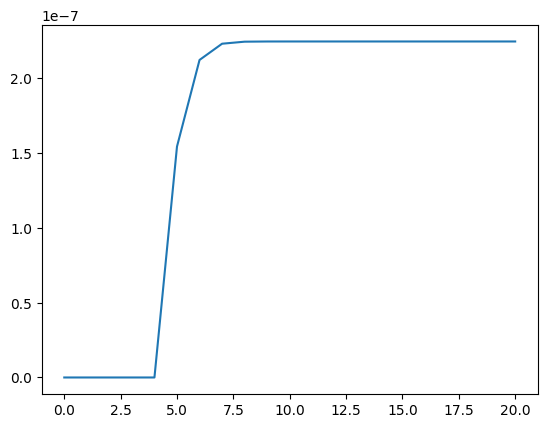

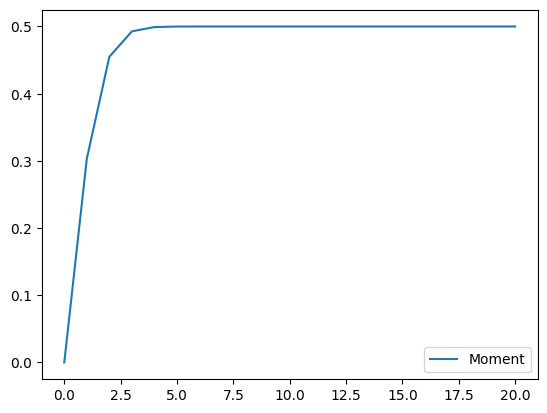

In [10]:
rate = 2
beta = 0.25
M = 20
x_OB = 5
p1 = scipy.stats.poisson.pmf(np.array([x1 for x1 in range(0, M + 1)])[:, None], beta * rate).mean(axis=1)
B_coefs = np.array([B(x_OB, x_OG, beta) for x_OG in range(M + 1)])
M_coefs = np.arange(M + 1)
prob_terms = p1 * B_coefs
moment_terms = p1 * M_coefs
cum_prob_terms = np.cumsum(prob_terms)
cum_moment_terms = np.cumsum(moment_terms)
'''
Need to run log10 lines twice to avoid numpy bug taking random values from memory rather than leaving as 0.0
'''
log_cum_prob_terms = np.log10(cum_prob_terms, where=(cum_prob_terms!=0.0))
log_cum_prob_terms = np.log10(cum_prob_terms, where=(cum_prob_terms!=0.0))
log_cum_moment_terms = np.log10(cum_moment_terms, where=(cum_moment_terms!=0.0))
log_cum_moment_terms = np.log10(cum_moment_terms, where=(cum_moment_terms!=0.0))
plt.plot(cum_prob_terms, label="Prob")
plt.show()
plt.plot(cum_moment_terms, label="Moment")
plt.legend()